In [1]:
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# functions

In [2]:
def compute_RMSE(diff):
    if len(diff)>0:
        return np.sqrt(np.mean(diff.values**2))
        
def compute_MAE(diff):
    if len(diff)>0:
        return np.mean(np.abs(diff.values))

def plot_errors(plotcols, test_data, train_data):
    test_diff = test_data['outofsample_error']
    train_diff = train_data['insample_error']
    
    test_data['RMSE'] = test_diff.resample('D').apply(compute_RMSE).dropna()
    test_data['MAE'] = test_diff.resample('D').apply(compute_MAE).dropna()
    test_plot = test_data[plotcols].copy().drop_duplicates()
    
    train_data['RMSE'] = train_diff.resample('D').apply(compute_RMSE).dropna()
    train_data['MAE'] = train_diff.resample('D').apply(compute_MAE).dropna()
    train_plot = train_data[plotcols].copy().drop_duplicates()
    
    fig,axs = plt.subplots(len(plotcols),figsize=(10,10),sharex=True)
    for i,col in enumerate(plotcols):
        axs[i].plot(train_plot[col],color='green',label='in-sample')
        axs[i].set_title(col.replace('_',' '))
        axs[i].legend()
    for i,col in enumerate(plotcols):
        axs[i].plot(test_plot[col],color='purple',label='out-of-sample')
        axs[i].set_title(col.replace('_',' '))
        axs[i].legend()
    plt.show()

def retrain(old_train_data,old_test_data,train_to_date):
    new_train = pd.concat([old_train_data,old_test_data[old_test_data.index<=train_to_date]],ignore_index=False).dropna(how='any',axis=1).reset_index(drop=False)
    new_test = old_test_data[~old_test_data.index.isin(new_train['calculation_date'])].copy().reset_index(drop=False)
    arrs = trainer.get_train_test_arrays(new_train, new_test)
    train_X = arrs['train_X']
    train_y = arrs['train_y']
    test_X = arrs['test_X']
    test_y = arrs['test_y']
    preprocessor = trainer.preprocess()
    retrained_model = trainer.run_dnn(preprocessor,train_X,train_y)
    train_data, test_data, errors = trainer.test_prediction_accuracy(retrained_model,new_test,new_train)
    new_test_data = test_data.set_index('calculation_date')
    new_train_data = train_data.set_index('calculation_date')
    print()
    plot_errors(plotcols,new_test_data,new_train_data)
    return new_train_data, new_test_data


# """
# from sklearn.inspection import partial_dependence,PartialDependenceDisplay

# part_disp_X = train_data[model_fit.feature_names_in_]
# fig, ax = plt.subplots(figsize=(12, 6))
# disp = PartialDependenceDisplay.from_estimator(model_fit, part_disp_X, model_fit.feature_names_in_, ax=ax)

# part_disp_X = insample[retrained_model.feature_names_in_]
# fig, ax = plt.subplots(figsize=(12, 6))
# disp = PartialDependenceDisplay.from_estimator(retrained_model, part_disp_X, model_fit.feature_names_in_, ax=ax)
# """

# loading model

In [3]:
from model_settings import ms
root = Path().resolve().parent.parent
models_dir = os.path.join(root,ms.trained_models)
models = [f for f in os.listdir(models_dir) if f.find('ipynb')==-1]
for i,m in enumerate(models):
    print(f"{i}     {m}")

0     2024_10_29 100027150881 bloomberg barrier options
1     2024_10_29 100220915287 bloomberg asian options
2     2024_10_29 122031053637 bloomberg asian options


# loading data

0     2024_10_29 122031053637 bloomberg asian options insample.csv
1     2024_10_29 122031053637 bloomberg asian options outsample.csv
2     2024_10_29 122031053637 bloomberg asian options.pkl
3     2024_10_29 122031053637 bloomberg asian options.txt

spot price 
0        676.03
1        682.43
2        683.09
3        696.44
4        701.13
         ...   
1076    1461.17
1077    1461.21
1078    1461.31
1079    1461.36
1080    1465.27
Name: spot_price, Length: 1081, dtype: float64

strike price 
0        338.0
1        341.0
2        348.0
3        350.0
4        356.0
         ...  
2362    2189.0
2363    2190.0
2364    2191.0
2365    2192.0
2366    2197.0
Name: strike_price, Length: 2367, dtype: float64

days to maturity 
0      1
1      7
2     28
3     84
4    168
5    336
Name: days_to_maturity, dtype: int64

risk free rate 
0    0.04
Name: risk_free_rate, dtype: float64

dividend rate 
0      0.017912
1      0.017942
2      0.017970
3      0.017981
4      0.017985
         ...  

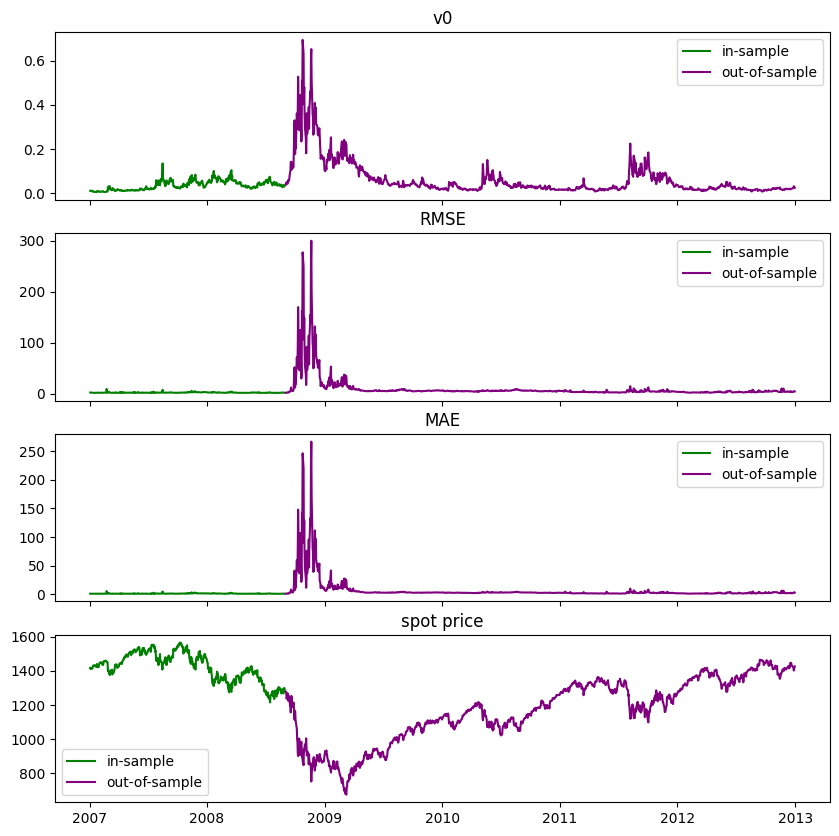

In [4]:
"""
select model here
"""
model = models[2]
""""""

plotcols = ['v0','RMSE', 'MAE','spot_price']

from convsklearn import asian_trainer, barrier_trainer

model_dir = os.path.join(models_dir,model)
model_files = [f for f in os.listdir(model_dir) if f.find('ipynb')==-1 and f.find('.html')==-1]
for i,m in enumerate(model_files):
    print(f"{i}     {m}")
print()
if any('asian' in file for file in model_files):
    trainer = asian_trainer
if any('barrier' in file for file in model_files):
    trainer = barrier_trainer

train_data = pd.read_csv(os.path.join(model_dir,[f for f in model_files if f.find('insample')!=-1][0])).iloc[:,1:].copy()
test_data = pd.read_csv(os.path.join(model_dir,[f for f in model_files if f. find('outsample')!=-1][0])).iloc[:,1:].copy()
train_data['calculation_date'] = pd.to_datetime(train_data['calculation_date'])
test_data['calculation_date'] = pd.to_datetime(test_data['calculation_date'])
train_data = train_data.set_index('calculation_date')
test_data = test_data.set_index('calculation_date')
outsample_dates = pd.Series(test_data.index).sort_values(ascending=True).drop_duplicates().reset_index(drop=True)
model_fit = joblib.load(os.path.join(model_dir,[f for f in model_files if f.endswith('.pkl')][0]))

for col in trainer.feature_set:
    print(f"{col.replace("_"," "):}",f"\n{test_data[col].copy().squeeze().sort_values().drop_duplicates().reset_index(drop=True)}\n")
print()
print(model_fit)

plot_errors(plotcols, test_data, train_data)

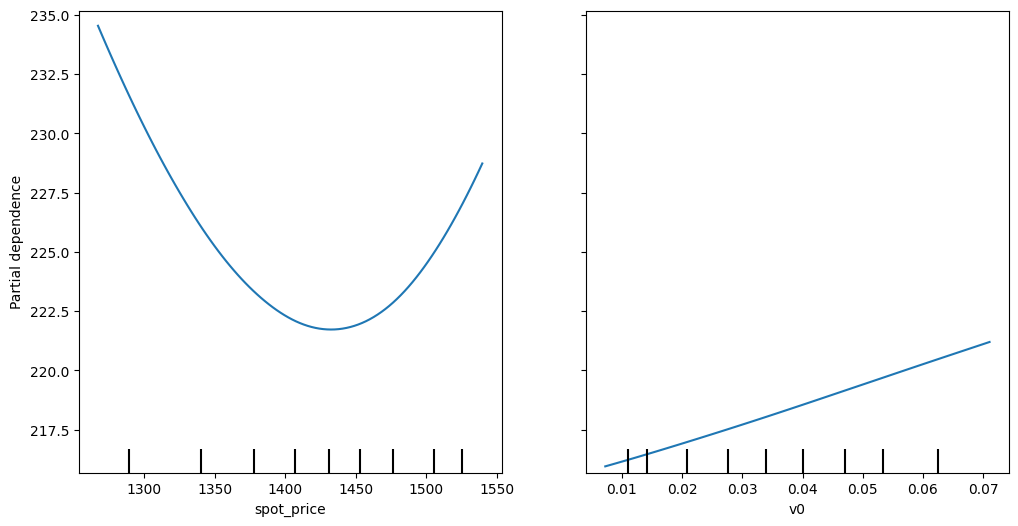

In [5]:
from sklearn.inspection import partial_dependence,PartialDependenceDisplay

part_disp_X = train_data[model_fit.feature_names_in_]
fig, ax = plt.subplots(figsize=(12, 6))
disp = PartialDependenceDisplay.from_estimator(model_fit, part_disp_X, ['spot_price','v0'], ax=ax)

# retraining

In [6]:
retraining_frequency = 100  # days
retraining_i = np.arange(retraining_frequency,len(outsample_dates),retraining_frequency)
retraining_dates = outsample_dates[retraining_i].reset_index(drop=True)
print(retraining_dates)

0   2009-01-26
1   2009-06-18
2   2009-11-09
3   2010-04-06
4   2010-08-26
5   2011-01-19
6   2011-06-13
7   2011-11-02
8   2012-03-28
9   2012-08-20
Name: calculation_date, dtype: datetime64[ns]



Mon Jan 26 00:00:00 2009

training...

alpha: 0.01
hidden_layer_sizes: (15, 15)
learning_rate: adaptive
learning_rate_init: 0.1
solver: sgd
early_stopping: False
max_iter: 500
warm_start: True
tol: 0.0001
cpu: 30.290140390396118

in sample:
     RMSE: 3.5127747464120733
     MAE: 1.9987184840561507

out of sample:
     RMSE: 3.6103776194876214
     MAE: 2.313797408944185



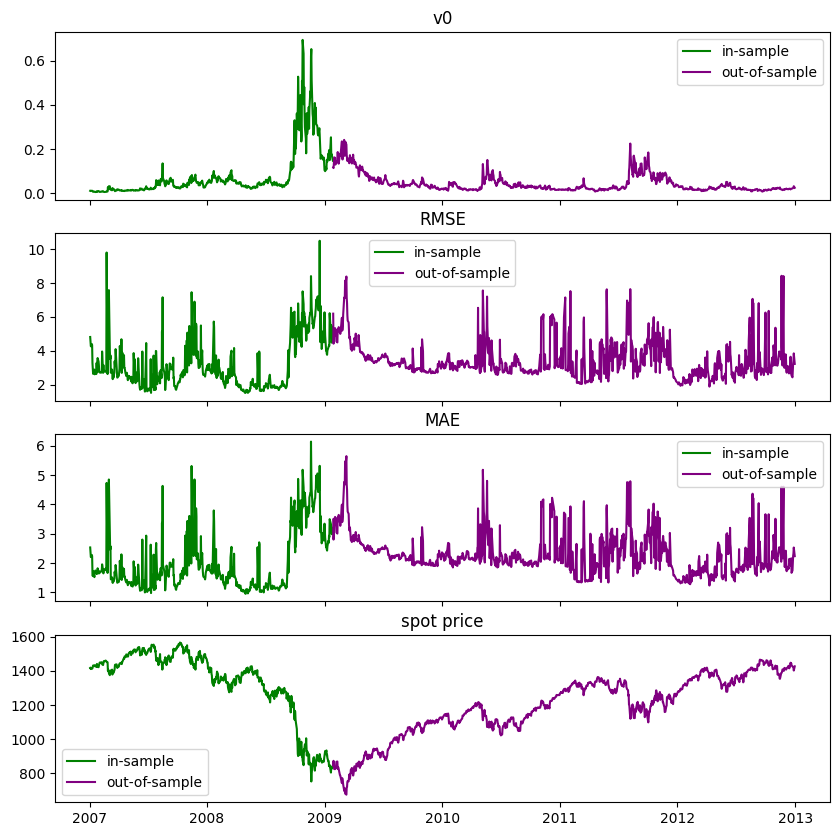



Thu Jun 18 00:00:00 2009

training...

alpha: 0.01
hidden_layer_sizes: (15, 15)
learning_rate: adaptive
learning_rate_init: 0.1
solver: sgd
early_stopping: False
max_iter: 500
warm_start: True
tol: 0.0001
cpu: 38.36277961730957

in sample:
     RMSE: 2.9678335370505162
     MAE: 1.6994139494793559

out of sample:
     RMSE: 2.6889558398377464
     MAE: 1.6538130145629246



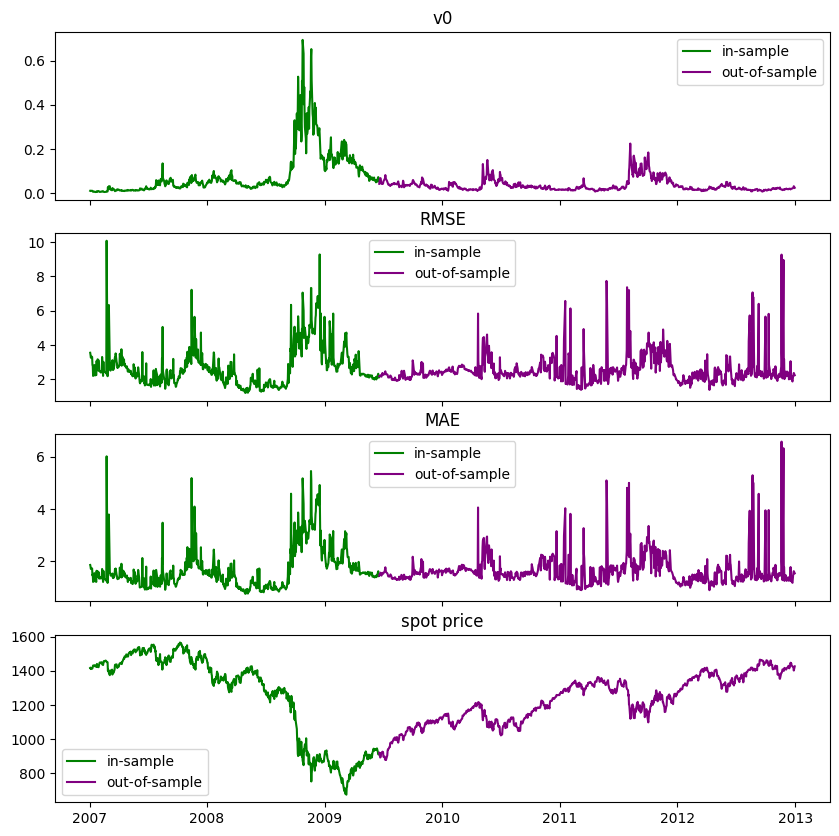



Mon Nov  9 00:00:00 2009

training...

alpha: 0.01
hidden_layer_sizes: (15, 15)
learning_rate: adaptive
learning_rate_init: 0.1
solver: sgd
early_stopping: False
max_iter: 500
warm_start: True
tol: 0.0001
cpu: 46.1227011680603

in sample:
     RMSE: 3.0119915098874213
     MAE: 1.6646370918199294

out of sample:
     RMSE: 2.508092297016635
     MAE: 1.4433093835387305



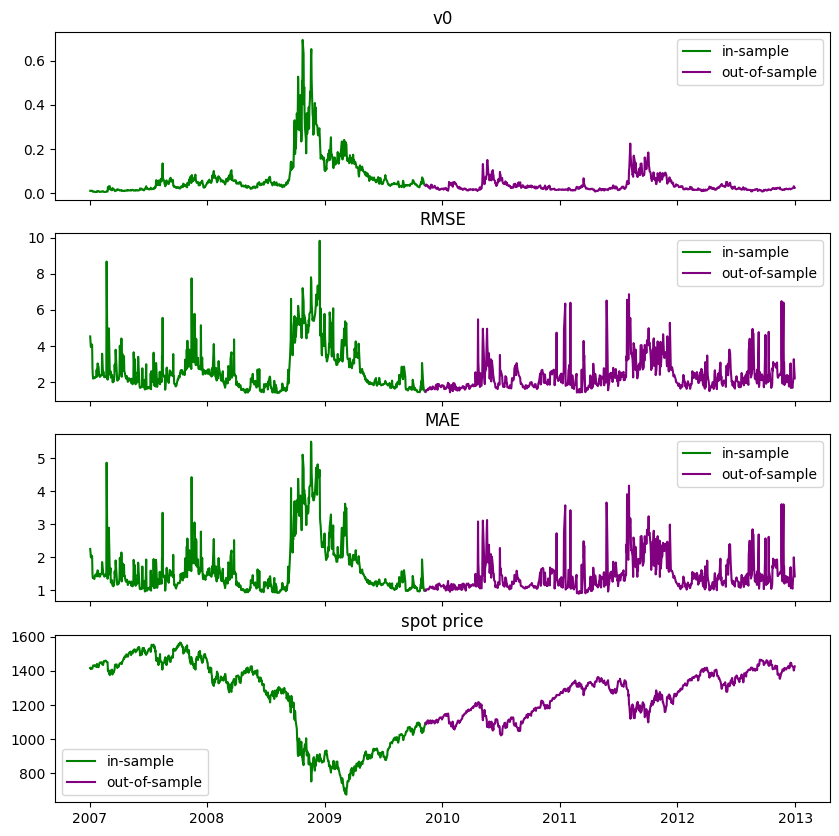



Tue Apr  6 00:00:00 2010

training...

alpha: 0.01
hidden_layer_sizes: (15, 15)
learning_rate: adaptive
learning_rate_init: 0.1
solver: sgd
early_stopping: False
max_iter: 500
warm_start: True
tol: 0.0001
cpu: 51.28092956542969

in sample:
     RMSE: 2.8378582690721212
     MAE: 1.5913345507233472

out of sample:
     RMSE: 2.7775093155537216
     MAE: 1.5617277919562274



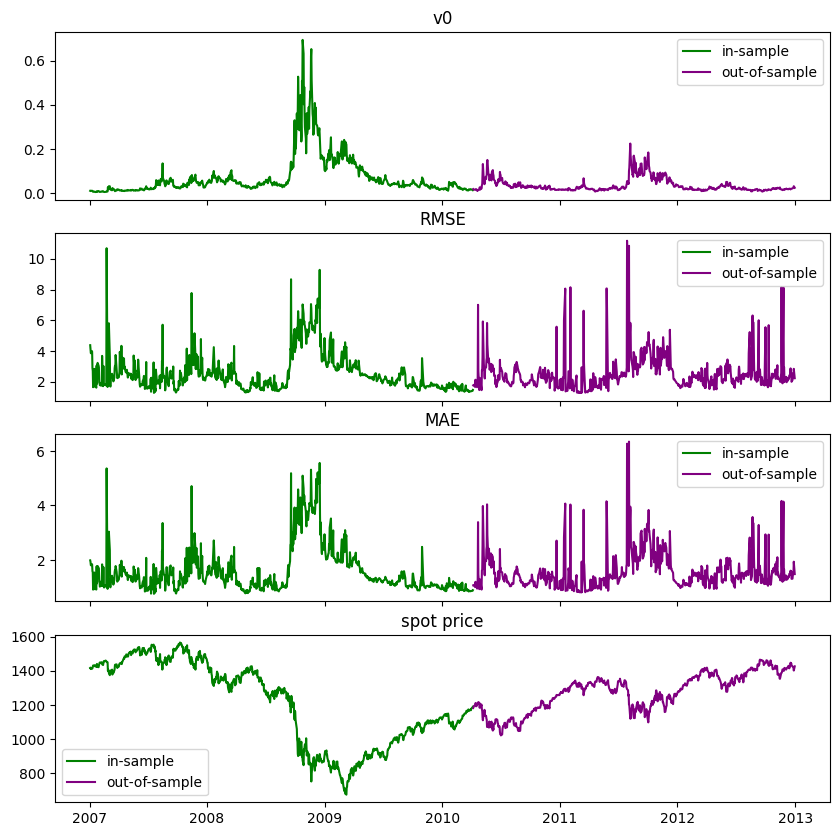



Thu Aug 26 00:00:00 2010

training...

alpha: 0.01
hidden_layer_sizes: (15, 15)
learning_rate: adaptive
learning_rate_init: 0.1
solver: sgd
early_stopping: False
max_iter: 500
warm_start: True
tol: 0.0001
cpu: 57.5985643863678

in sample:
     RMSE: 2.8866288013638375
     MAE: 1.587904357444384

out of sample:
     RMSE: 2.639954060304299
     MAE: 1.5261251591694982



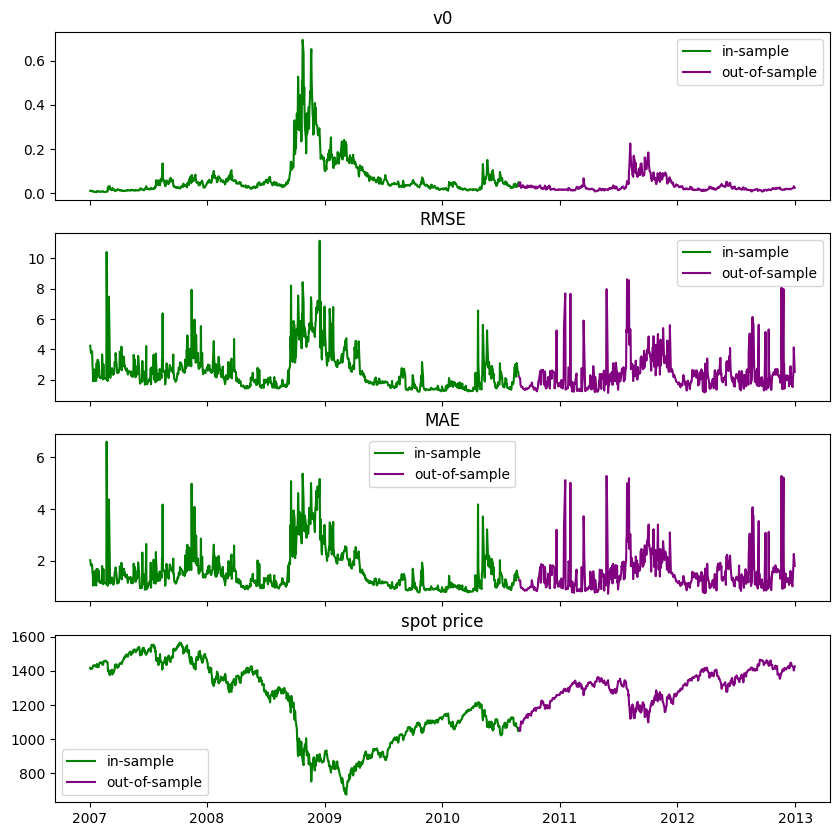



Wed Jan 19 00:00:00 2011

training...

alpha: 0.01
hidden_layer_sizes: (15, 15)
learning_rate: adaptive
learning_rate_init: 0.1
solver: sgd
early_stopping: False
max_iter: 500
warm_start: True
tol: 0.0001
cpu: 62.359501361846924

in sample:
     RMSE: 2.5743372703042913
     MAE: 1.4155112735328343

out of sample:
     RMSE: 2.452734671077847
     MAE: 1.3731348648840267



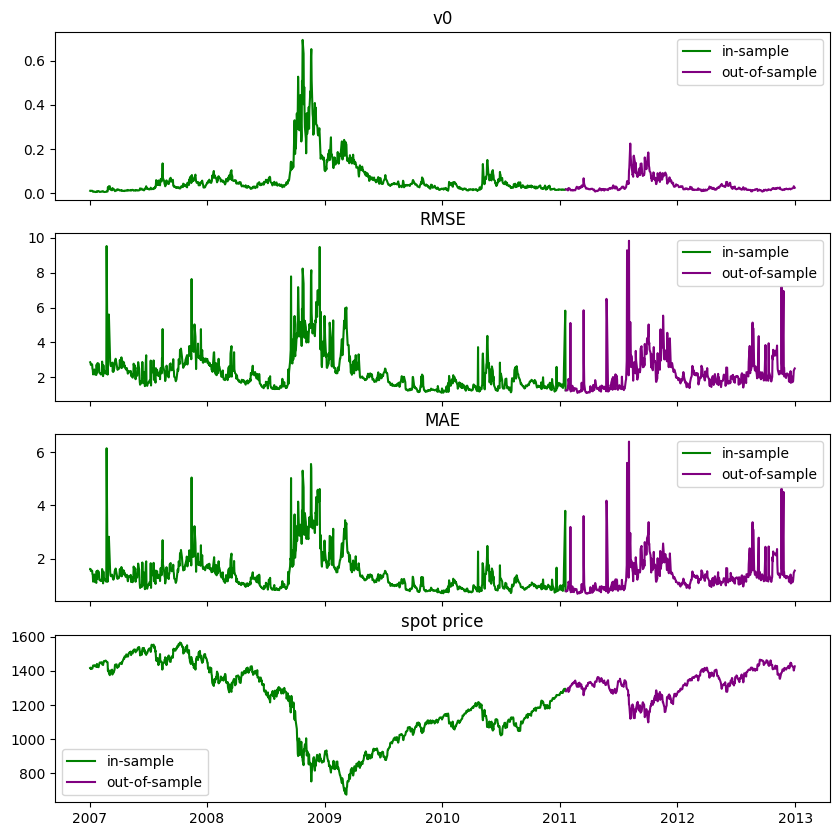



Mon Jun 13 00:00:00 2011

training...

alpha: 0.01
hidden_layer_sizes: (15, 15)
learning_rate: adaptive
learning_rate_init: 0.1
solver: sgd
early_stopping: False
max_iter: 500
warm_start: True
tol: 0.0001
cpu: 65.18511867523193

in sample:
     RMSE: 2.472649067380223
     MAE: 1.4107797529979422

out of sample:
     RMSE: 2.3417581374740717
     MAE: 1.366368757693757



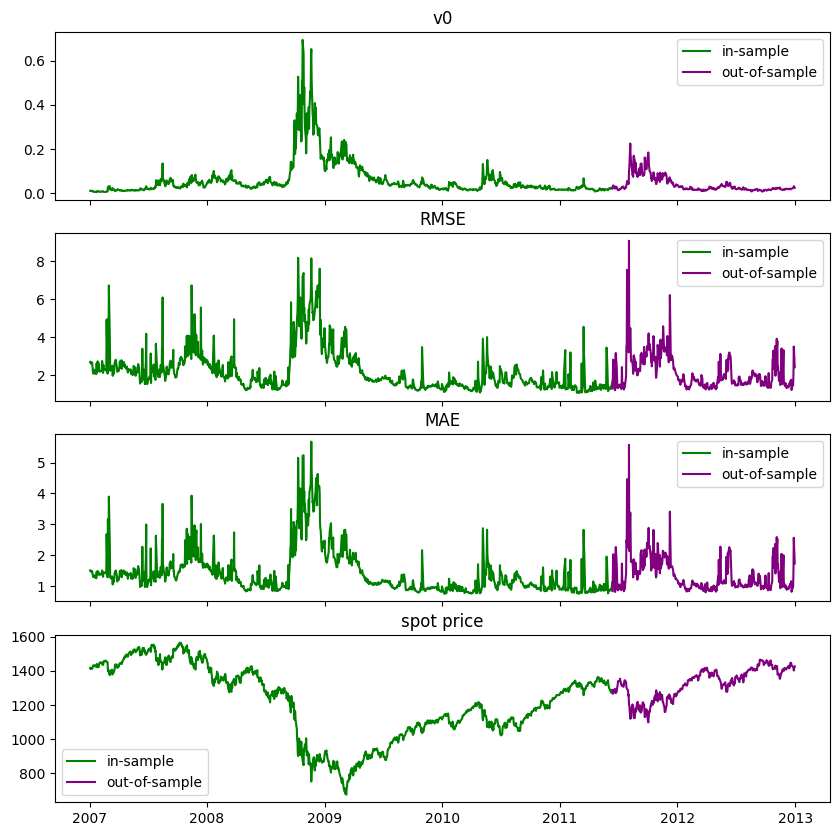



Wed Nov  2 00:00:00 2011

training...

alpha: 0.01
hidden_layer_sizes: (15, 15)
learning_rate: adaptive
learning_rate_init: 0.1
solver: sgd
early_stopping: False
max_iter: 500
warm_start: True
tol: 0.0001
cpu: 74.39733219146729

in sample:
     RMSE: 2.3899084176599144
     MAE: 1.3674000709734762

out of sample:
     RMSE: 1.8846378852447776
     MAE: 1.0718097532520139



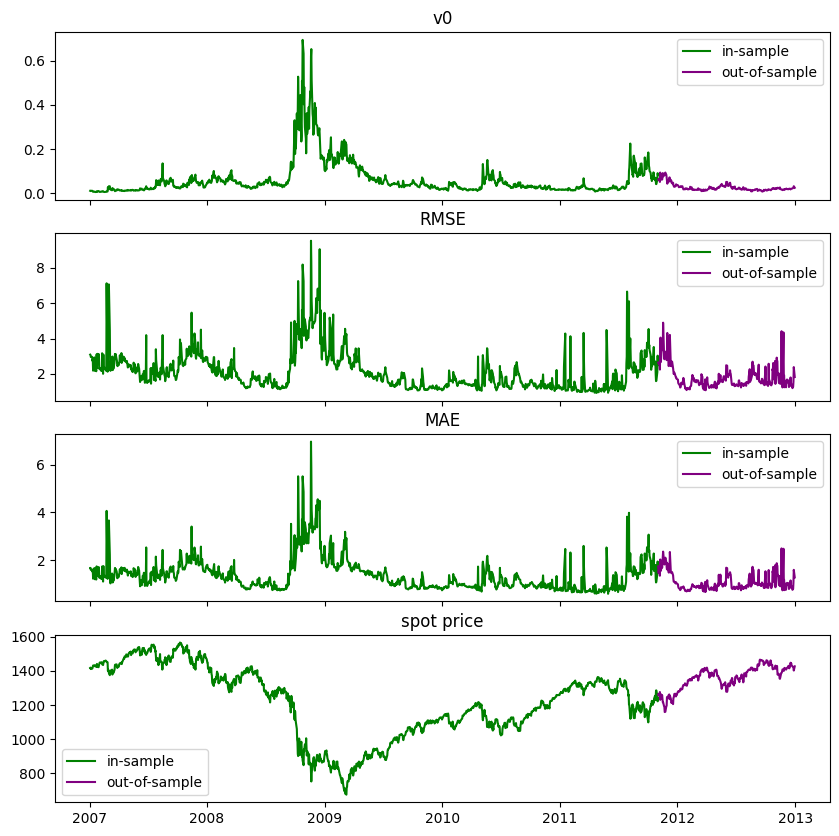



Wed Mar 28 00:00:00 2012

training...

alpha: 0.01
hidden_layer_sizes: (15, 15)
learning_rate: adaptive
learning_rate_init: 0.1
solver: sgd
early_stopping: False
max_iter: 500
warm_start: True
tol: 0.0001
cpu: 79.66719937324524

in sample:
     RMSE: 2.8193003738209734
     MAE: 1.5904780492638857

out of sample:
     RMSE: 2.1150493960988617
     MAE: 1.2837755895965823



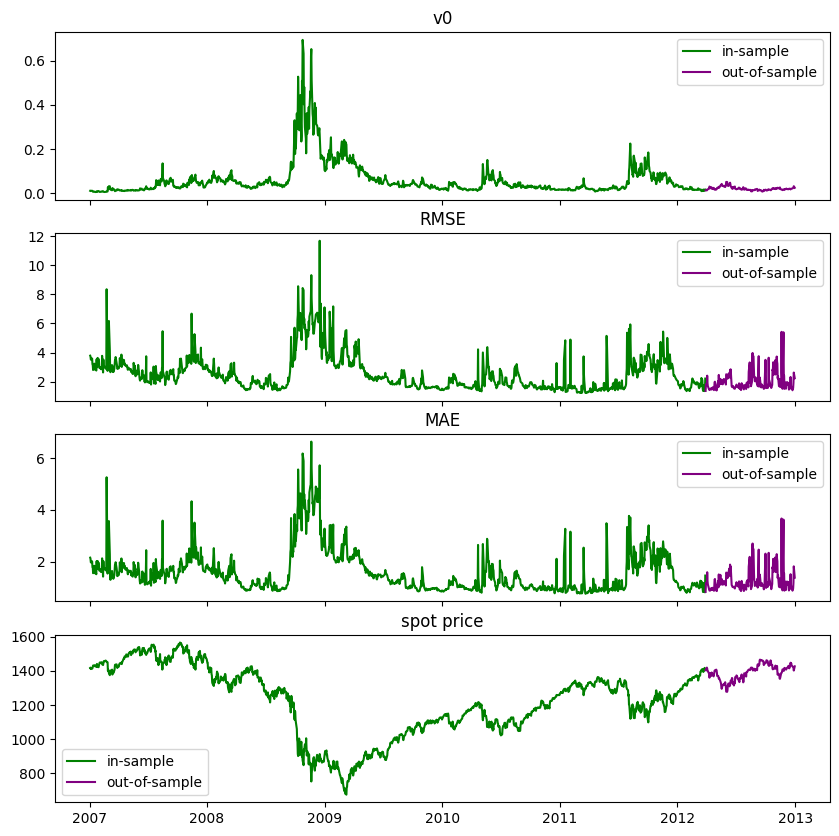



Mon Aug 20 00:00:00 2012

training...

alpha: 0.01
hidden_layer_sizes: (15, 15)
learning_rate: adaptive
learning_rate_init: 0.1
solver: sgd
early_stopping: False
max_iter: 500
warm_start: True
tol: 0.0001
cpu: 87.31256556510925

in sample:
     RMSE: 2.561544598430347
     MAE: 1.3933722043748384

out of sample:
     RMSE: 2.112106820548709
     MAE: 1.1790049035897177



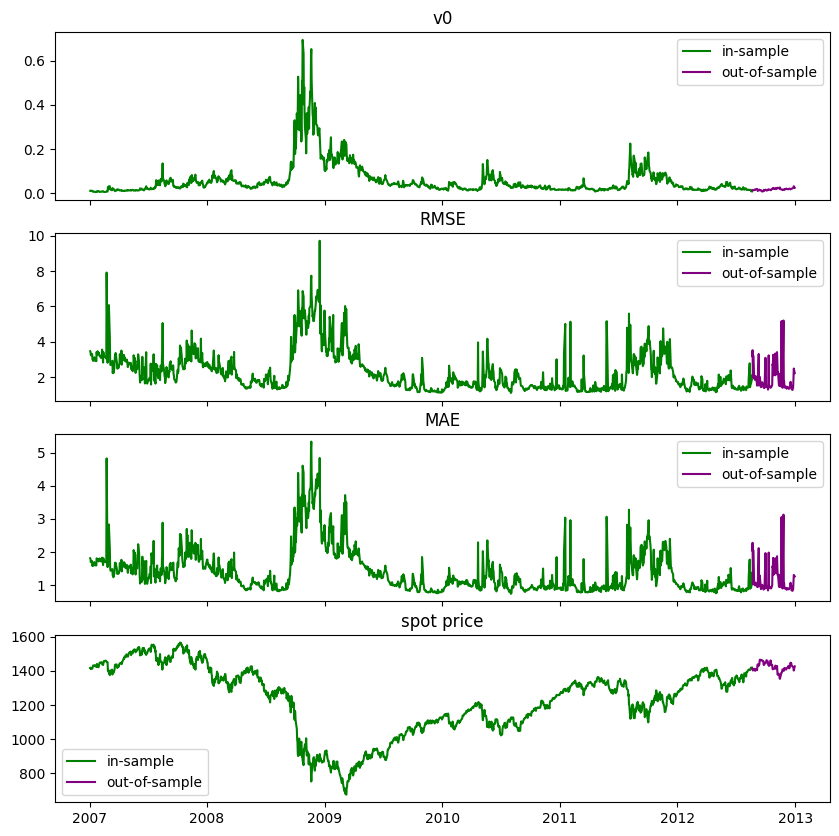

In [7]:
for date in retraining_dates:
    print()
    print(date.strftime('%c'))
    retrain(train_data,test_data,date)
    print()